In [1]:
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import stats

In [2]:
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4
plt.rcParams['legend.borderpad'] = 0.5
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=22)


[Стратификация. Как разбиение выборки повышает чувствительность A/B теста](https://habr.com/ru/company/X5Tech/blog/596279/)

# 1. Генерация данных.

Для простоты будем считать, что у нас две страты, которые представлены в одинаковых пропорциях в генеральной совокупности.

Напишем функции генерирования данных для случайного и стратифицированного сэмплирования.

In [3]:
def generate_random_data(sample_size, mean_one, mean_two, std=1):
    """Генерируем две выборки с случайным сэмплированием.
    
    sample_size - размер выборки
    mean_one, mean_two - средние значения в стратах
    std - среднеквадратичное отклонение
    
    return - [df_one, df_two], пара pd.DataFrame со столбцами ['strat', 'metric'],
        где столбце 'strat' содержится идентификатор страты, а в 'metric' - значения метрики.
    """
    df_one = pd.DataFrame({'strat': 0, 'metric': np.random.normal(mean_one, std, sample_size)})
    df_two = pd.DataFrame({'strat': 1, 'metric': np.random.normal(mean_two, std, sample_size)})
    df = pd.concat([df_one, df_two], ignore_index=True).sample(sample_size * 2)
    dfs = [df.iloc[:sample_size].copy(), df.iloc[sample_size:].copy()]
    return dfs


def generate_stratified_data(sample_size, mean_one, mean_two, std=1):
    """Генерируем две выборки с стратифицированным сэмплированием.
    
    sample_size - размер выборки
    mean_one, mean_two - средние значения в стратах
    std - среднеквадратичное отклонение
    
    return - [df_one, df_two], пара pd.DataFrame со столбцами ['strat', 'metric'],
        где столбце 'strat' содержится идентификатор страты, а в 'metric' - значения метрики.
    """
    size_strata_one = int(sample_size / 2)
    size_strata_two = sample_size - size_strata_one
    dfs = []
    for _ in range(2):
        metric = np.hstack([
            np.random.normal(mean_one, std, size_strata_one),
            np.random.normal(mean_two, std, size_strata_two)
        ])
        strat = np.hstack([
            np.zeros(size_strata_one),
            np.ones(size_strata_two)
        ]).astype(int)
        df = pd.DataFrame({'strat': strat, 'metric': metric})
        dfs.append(df)
    return dfs

In [4]:
sample_size = 6
mean_one = 5
mean_two = 10

dfs_srs = generate_random_data(sample_size, mean_one, mean_two)
dfs_srs[0]

,strat,metric
7,1,8.704067
6,1,8.557401
1,0,5.528690
4,0,3.849912
3,0,4.740941
2,0,5.529621


In [5]:
dfs_strat = generate_stratified_data(sample_size, mean_one, mean_two)
dfs_strat[0]

,strat,metric
0,0,6.196229
1,0,4.747780
2,0,5.410053
3,1,10.573588
4,1,8.452261
5,1,10.473194


# 2. Вычисление среднего

Нам необходимо оценить популяционное среднее бизнес метрики $Y$.


1. $\mu = \mathbb{E} Y$ – популяционное среднее;

2. $\sigma^2 = \mathbb{V} Y$ – популяционная дисперсия;

3. $\mu_k$, $\sigma_k^2$ – среднее значение и дисперсия бизнес метрики для $k$-й страты;

4. $w_k$ – доля $k$-й страты в популяции;

5. $n_k$ – число пользователей из $k$-й страты в рассматриваемой группе;

6. $n = \sum_{k=1}^K n_k$ – общий размер группы.

7. $Y_{11},\ldots Y_{1n_1},\ldots Y_{K1},\ldots Y_{Kn_K}$ – выборка из г.с., где $Y_{kj}$ --- метрика для $j$-го пользователя $k$-й страты.


Для популяционного среднего можно рассмотреть две несмещенные точечные оценки:

1. **Простое среднее**
$$\overline{Y} = \frac{1}{n} \sum_{k=1}^K \sum_{j=1}^{n_k} Y_{kj} = \frac{1}{n} \sum_{i=1}^n Y_i$$ 

2. **Взвешенное среднее (стратифицированное среднее)**
$$ \hat{Y}_{strat} = \sum_{k=1}^K w_k \overline{Y}_k, \quad
\overline{Y}_k = \frac{1}{n_k} \sum_{j=1}^{n_k} Y_{kj}$$

In [6]:
def calculate_mean(df):
    """Вычисляет обычное среднее по столбцу 'metric'."""
    return df['metric'].mean()


def calculate_stratified_mean(df, weights):
    """Вычисляет стратифицированное среднее.

    df - датафрейм с целевой метрикой и данными для стратификации
    weights - словарь - {название страты: вес страты}

    return: float, mean_strat
    """
    strat_mean = df.groupby('strat')['metric'].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights['metric']).sum()
    return mean_strat

Проверим равенство математических ожиданий средних:
$\mathbb{E}_{srs}(\hat{Y}_{strat}) = \mathbb{E}_{srs}(\overline{Y})$.

Будем генерировать данные с помощью случайного сэмплирования и записывать значения средних. Затем посчитаем их среднее значение как оценку математичкского ожидания.

  0%|          | 0/3000 [00:00<?, ?it/s]

mean(means) = 7.49, mean(strat_means) = 7.50


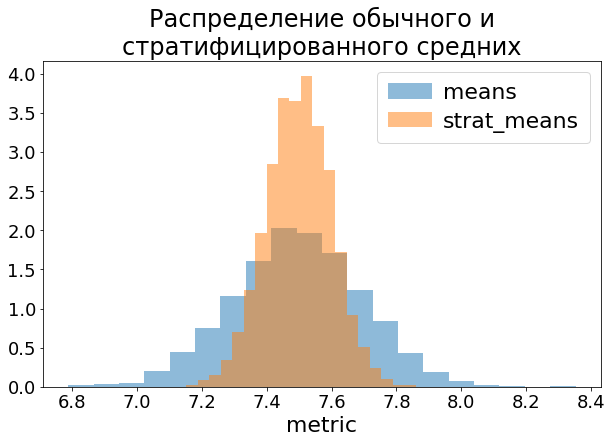

In [7]:
sample_size = 100
mean_one = 5
mean_two = 10
weights = {0: 0.5, 1: 0.5}

means = []
strat_means = []
for _ in tqdm(range(3000)):
    df = generate_random_data(sample_size, mean_one, mean_two)[0]
    means.append(calculate_mean(df))
    strat_means.append(calculate_stratified_mean(df, weights))


print(f'mean(means) = {np.mean(means):0.2f}, mean(strat_means) = {np.mean(strat_means):0.2f}')

plt.hist(means, bins=20, alpha=0.5, density=True, label='means')
plt.hist(strat_means, bins=20, alpha=0.5, density=True, label='strat_means')
plt.xlabel('metric')
plt.title('Распределение обычного и\nстратифицированного средних')
plt.legend()
plt.show()

- получили распределения с близкими средними;
- разброс у стратифицированного среднего меньше.

# 3. Виды стратификации

**стратификация:**
стратифицированное семплирование $STRAT$ + Взвешенное среднее

**постстратификация:**
случайное семплирование $SRS$ + Взвешенное среднее

**без стратификации:**
случайное семплирование $SRS$ + Простое среднее


1. **Простое среднее**
$$\overline{Y} = \frac{1}{n} \sum_{k=1}^K \sum_{j=1}^{n_k} Y_{kj} = \frac{1}{n} \sum_{i=1}^n Y_i$$ 

2. **Взвешенное среднее (стратифицированное среднее)**
$$ \hat{Y}_{strat} = \sum_{k=1}^K w_k \overline{Y}_k, \quad
\overline{Y}_k = \frac{1}{n_k} \sum_{j=1}^{n_k} Y_{kj}$$

# Дисперсия

### Зависимость от размера выборки

Будем увеличивать размер выборок и для каждого размера выборки вычислять оценку среднего несколько раз, чтобы затем оценить разброс.

  0%|          | 0/6 [00:00<?, ?it/s]

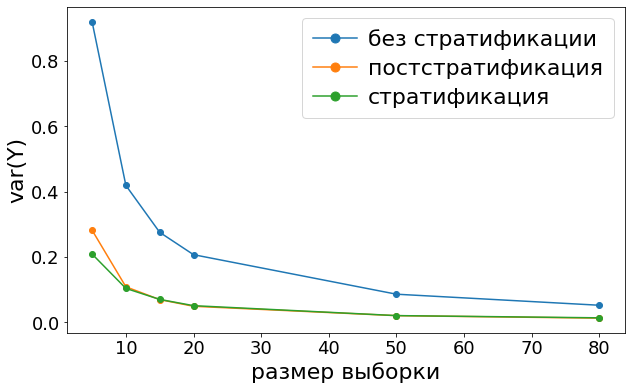

In [8]:
mean_one = 0
mean_two = 5
weights = {0: 0.5, 1: 0.5}
sample_sizes = [5, 10, 15] + list(range(20, 81, 30))

var_random_means = []
var_poststratified_means = []
var_stratified_means = []

for sample_size in tqdm(sample_sizes):
    random_means = []
    poststratified_means = []
    stratified_means = []
    for _ in range(1000):
        df_srs = generate_random_data(sample_size, mean_one, mean_two)[0]
        df_strat = generate_stratified_data(sample_size, mean_one, mean_two)[0]
        random_means.append(calculate_mean(df_srs))
        poststratified_means.append(calculate_stratified_mean(df_srs, weights))
        stratified_means.append(calculate_stratified_mean(df_strat, weights))
    var_random_means.append(np.var(random_means))
    var_poststratified_means.append(np.var(poststratified_means))
    var_stratified_means.append(np.var(stratified_means))

plt.plot(sample_sizes, var_random_means, '-o', label='без стратификации')
plt.plot(sample_sizes, var_poststratified_means, '-o', label='постстратификация')
plt.plot(sample_sizes, var_stratified_means, '-o', label='стратификация')
plt.xlabel('размер выборки')
plt.ylabel('var(Y)')
plt.legend()
plt.show()

- при увеличении sample_size дисперсия при постстратификации быстро приближается к дисперсии при стратификации;
- отличия дисперсий всех способов при увеличении sample_size уменьшаются.

### Зависимость от разницы средних значений страт

Проведём аналогичный эксперимент, только теперь будем увеличивать среднее значение метрики у второй страты.

  0%|          | 0/6 [00:00<?, ?it/s]

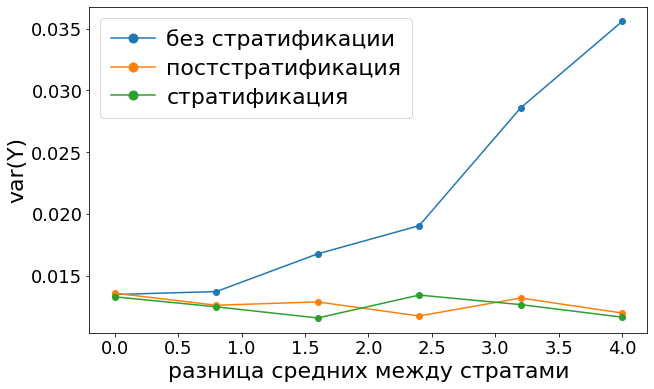

In [9]:
mean_one = 0
array_mean_two = np.linspace(0, 4, 6)
weights = {0: 0.5, 1: 0.5}
sample_sizes = 10

var_random_means = []
var_poststratified_means = []
var_stratified_means = []

for mean_two in tqdm(array_mean_two):
    random_means = []
    poststratified_means = []
    stratified_means = []
    for _ in range(1000):
        df_srs = generate_random_data(sample_size, mean_one, mean_two)[0]
        df_strat = generate_stratified_data(sample_size, mean_one, mean_two)[0]
        random_means.append(calculate_mean(df_srs))
        poststratified_means.append(calculate_stratified_mean(df_srs, weights))
        stratified_means.append(calculate_stratified_mean(df_strat, weights))
    var_random_means.append(np.var(random_means))
    var_poststratified_means.append(np.var(poststratified_means))
    var_stratified_means.append(np.var(stratified_means))

plt.plot(array_mean_two, var_random_means, '-o', label='без стратификации')
plt.plot(array_mean_two, var_poststratified_means, '-o', label='постстратификация')
plt.plot(array_mean_two, var_stratified_means, '-o', label='стратификация')
plt.xlabel('разница средних между стратами')
plt.ylabel('var(Y)')
plt.legend()
plt.show()

- при увеличении отличий между стратами дисперсия без использования стратификации увеличивается;
- изменение отличий между стратами не влияют на дисперсию при использовании стратификации и постстратификации;
- при отсутствии отличий между стратами, дисперсии всех трёх методов совпадают.

# 4. Оценка экспериментов

In [10]:
def check_test(df_control, df_pilot):
    """Проверяет гипотезу о равенстве средних для обычного среднего.
    
    return - pvalue.
    """
    values_control = df_control['metric'].values
    values_pilot = df_pilot['metric'].values
    _, pvalue = stats.ttest_ind(values_control, values_pilot)
    return pvalue


def calculate_strat_var(df, weights):
    """Вычисляет стратифицированную дисперсию."""
    strat_vars = df.groupby('strat')['metric'].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights['metric']).sum()
    return var_strat


def check_stratified_test(df_control, df_pilot, weights):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего.
    
    return - pvalue.
    """
    mean_strat_control = calculate_stratified_mean(df_control, weights)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights)
    var_strat_control = calculate_strat_var(df_control, weights)
    var_strat_pilot = calculate_strat_var(df_pilot, weights)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

Проверим что `check_stratified_test` работает корретно. Для этого применим к данным с одной стратой функции `check_stratified_test` и `check_test`. Результаты должны быть примерно одинаковы.

In [11]:
size = 10000
df_one = pd.DataFrame({'strat': 1, 'metric': np.random.normal(0, 1, size)})
df_two = pd.DataFrame({'strat': 1, 'metric': np.random.normal(0.01, 1, size)})

check_test(df_one, df_two), check_stratified_test(df_one, df_two, weights)

(0.11668523800284679, 0.11666941654373164)

## Оценка вероятностей ошибок первого рода

Проведём много AA тестов и построим распределение p-value. p-value должно быть распределено равномерно.

  0%|          | 0/1000 [00:00<?, ?it/s]

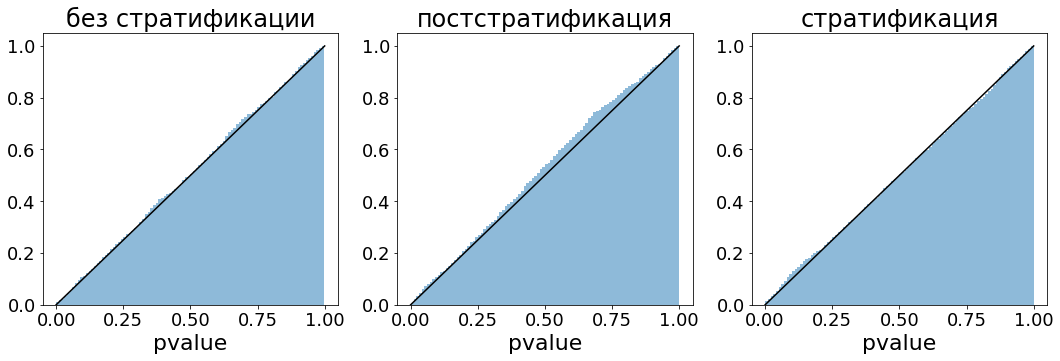

In [12]:
mean_one = 0
mean_two = 2
weights = {0: 0.5, 1: 0.5}
sample_sizes = 1000

pvalues_random = []
pvalues_poststratified = []
pvalues_stratified = []

for _ in tqdm(range(1000)):
    dfs_srs = generate_random_data(sample_size, mean_one, mean_two)
    dfs_strat = generate_stratified_data(sample_size, mean_one, mean_two)

    pvalues_random.append(check_test(*dfs_srs))
    pvalues_poststratified.append(check_stratified_test(*dfs_srs, weights))
    pvalues_stratified.append(check_stratified_test(*dfs_strat, weights))


_, axes = plt.subplots(1, 3, figsize=[18, 5])
list_pvalues = [pvalues_random, pvalues_poststratified, pvalues_stratified]
list_titles = ['без стратификации', 'постстратификация', 'стратификация']

for ax, pvalues, title in zip(axes, list_pvalues, list_titles):
    ax.hist(pvalues, bins=100, density=True, cumulative=True, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('pvalue')
    ax.plot([0, 1], [0, 1], 'k')
plt.show()

p-value распределено равномерно, все три способа показывают корректные результаты.

## Сравнение мощности тестов

Проведём много A/B тестов и построим распределение p-value. Распределение p-value должно быть выпуклым вверх. Чем более выпуклое, тем мощнее тест.

  0%|          | 0/1000 [00:00<?, ?it/s]

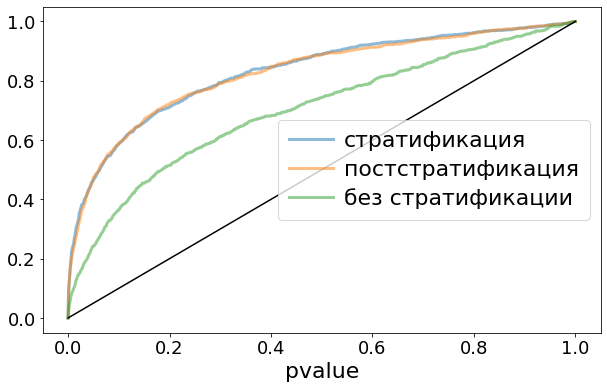

In [13]:
mean_one = 0
mean_two = 2
weights = {0: 0.5, 1: 0.5}
sample_sizes = 1000

pvalues_random = []
pvalues_poststratified = []
pvalues_stratified = []

for _ in tqdm(range(1000)):
    dfs_srs = generate_random_data(sample_size, mean_one, mean_two)
    dfs_strat = generate_stratified_data(sample_size, mean_one, mean_two)

    # add effect
    effect = np.random.normal(0.3, 0.1, sample_size)
    dfs_srs[1]['metric'] += effect
    dfs_strat[1]['metric'] += effect
    
    pvalues_random.append(check_test(*dfs_srs))
    pvalues_poststratified.append(check_stratified_test(*dfs_srs, weights))
    pvalues_stratified.append(check_stratified_test(*dfs_strat, weights))


list_pvalues = [pvalues_random, pvalues_poststratified, pvalues_stratified]
list_titles = ['без стратификации', 'постстратификация', 'стратификация']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

Методы с использованием стратификации обладают большей мощностью, а значит и большей чувствительностью.

# 5. Данные пиццерии

Посмотрим, как работает стратификация на примере данных пиццерии.

In [14]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-04-01/2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_user_strats = read_database('user_strats.csv')

df_sales - информация о покупках, одна строка - один заказ. Атрибуты:
- sale_id - идентификатор покупки;
- date - дата покупки;
- count_pizza - количество пицц в заказе;
- count_drink - количество напитков в заказе;
- price - стоимость заказа;
- user_id - идентификатор пользователя.

In [15]:
df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


Описание страт:
- 1 — заходят только с мобильного устройства;
- 2 — заходят только с компьютера;
- 3 — заходят и с мобильного, и с компьютера.


In [16]:
df_user_strats.head()

,user_id,strat
0,000096,1
1,0000d4,1
2,0000de,1
3,0000e4,1
4,0000e7,1


In [17]:
df_user_strats['strat'].value_counts()

1    58285
3    53518
2    11644
Name: strat, dtype: int64

In [18]:
# считаем значения метрики
begin_date = datetime(2022, 3, 23)
end_date = datetime(2022, 3, 30)
df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_date) & (df_sales['date'] < end_date)]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price': 'metric'})
    .reset_index()  
)

df_metrics = pd.merge(df_metrics, df_user_strats, on='user_id', how='left')

Посмотрим, как отличаются средние значения между стратами

In [19]:
df_metrics.groupby('strat')[['metric']].mean()

,metric
strat,
1,1221.697525
2,1251.554174
3,1227.406882


Отличия небольшие. Посмотрим, поможет ли постстратификация увеличить чувствительность теста.

  0%|          | 0/1000 [00:00<?, ?it/s]

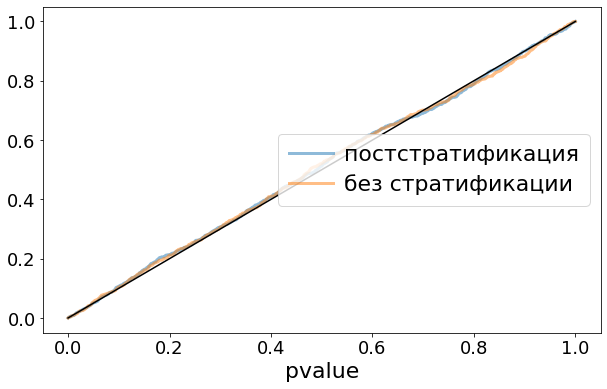

In [20]:
sample_size = 1000
weights = df_user_strats['strat'].value_counts(normalize=True).to_dict()
effect = 0

pvalues_random = []
pvalues_poststratified = []

for _ in tqdm(range(1000)):
    control_users, pilot_users = np.random.choice(df_metrics['user_id'].values, (2, sample_size,), False)
    df_control = df_metrics[df_metrics['user_id'].isin(control_users)].copy()
    df_pilot = df_metrics[df_metrics['user_id'].isin(pilot_users)].copy()
    df_pilot['metric'] += effect
    pvalues_random.append(check_test(df_control, df_pilot))
    pvalues_poststratified.append(check_stratified_test(df_control, df_pilot, weights))


list_pvalues = [pvalues_random, pvalues_poststratified]
list_titles = ['без стратификации', 'постстратификация']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

Отличия невооружённым глазом незаметны.